## Lab on Agent-based modeling

To use this notebook, run the cell below. In the future, try using Lab_week5 and download the Echolab3 folder...

This code has been adapted from Dawn C Walker and Mike Smith lectures from last years.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
#create default environment
env = Environment(shape=[60,60],growrate=60,maxgrass=5,startgrass=1)
    
#create agents (rabbits and foxes)
Nrabbits = 200
Nfoxes = 15
agents = []
for i in range(Nrabbits):
    r = Rabbit(position=env.get_random_location(),speed=1)
    agents.append(r)
for i in range(Nfoxes):
    f = Fox(position=env.get_random_location(),speed=3)
    agents.append(f)

In [8]:
#run the simulation (default = 1000 iterations)
record = run_ecolab(env,agents,Niterations=1000)

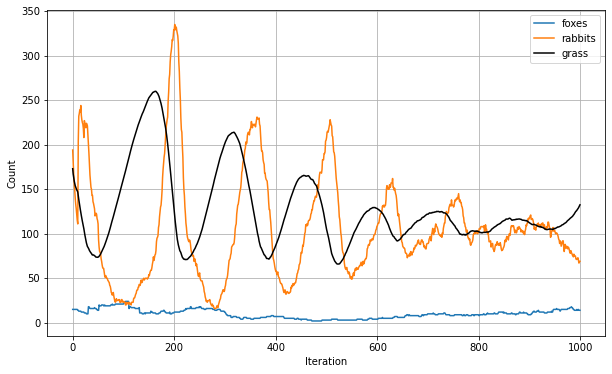

In [10]:
%matplotlib inline
counts = get_agent_counts(record)
plt.figure(figsize=[10,6])
plt.plot(counts[:,0],label='foxes')
plt.plot(counts[:,1],label='rabbits')
plt.plot(counts[:,2]/20,'k-',label='grass') #/20 to get on same scale
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Count');

## Exercise

- Familiarize with the simulation and try to answer to the following questions


- What happens if foxes' speed is increased?


- What happens if the number of foxes or rabbits are increased?


- In a specific setting of your choice (choice of parameters, environment size and so on), what is the maximum and minimum number of rabbits across a simulation of 1000 iterations? Quantify also their risk of extinction (the probabilty that rabbits would all die in the 1000 iterations of the simulation). Report your finding statistically (average, variance...).



### RUN THE CELLS BELOW

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#helper function
def argmax_2darray(a):
    """
    Returns the maximum location in a n-d array
    """
    return np.unravel_index(a.argmax(), a.shape)

class Environment:
    def __init__(self,shape=[40,40],startgrass=1,maxgrass=3,growrate=10):
        """
        Create the environment
        Parameters:
         - shape = shape of the environment
         - startgrass = initial amount of grass
         - maxgrass = maximum amount of grass allowed in each tile
         - growrate = number of tiles which get extra grass each iteration
        """
        self.maxgrass = maxgrass #maximum it can grow to
        self.growrate = growrate #how many new items of food added per step
        self.shape = shape #shape of the environment
        self.grass = np.full(self.shape,startgrass) #2*np.trunc(np.random.rand(*self.shape)*2)+2 #initial grass
        
        
    def get_food(self,position):
        """
        Returns the amount of food at position
        """
        return self.grass[int(position[0]),int(position[1])]
    
    def reduce_food(self,position,amount=1):
        """
        Reduce the amount of food at position by amount
        (note, doesn't check this doesn't go negative)
        """
        self.grass[int(position[0]),int(position[1])]-=amount
    
    def get_loc_of_grass(self,position,vision):
        """
        This finds the location of the cell with the maximum amount of food near 'pos',
        within a circle of 'vision' size.
        For example env.get_dir_of_food(np.array([3,3]),2)
        if two or more cells have the same food then it will select between them randomly.
        """
        
        ## The code below builds a new datastructure (the grid grasswithboundary) that has the same shape as the environment + 
        ## some 'borders' of lenght boundary that are all around the grid
        ## In this way, we can avoid problems that would arise on the boundary of the environment (we made it temporally larger...)
        ## The solution is not optimal, but it is relatively easy to program
        
        boundary = 10
        pos = position + boundary
        grasswithboundary = np.zeros(np.array(self.grass.shape)+boundary*2)
        grasswithboundary[boundary:-boundary,boundary:-boundary] = self.grass
        
        #we search just a circle within 'vision' tiles of 'pos' (these two commands build that search square)
        searchsquare = grasswithboundary[int(pos[0]-vision):int(pos[0]+vision+1),int(pos[1]-vision):int(pos[1]+vision+1)]
        searchsquare[(np.arange(-vision,vision+1)[:,None]**2 + np.arange(-vision,vision+1)[None,:]**2)>vision**2]=-1
        
        #the code below returns the location of that maximum food (with randomness added to equally weight same-food cells)         
        if np.all(searchsquare<=0): return None #no food found
        return argmax_2darray(searchsquare+0.01*np.random.rand(vision*2+1,vision*2+1))+position-vision
        

    def check_position(self,position):
        """
        Returns whether the position is within the environment
        """
        position[:] = np.round(position)
        if position[0]<0: return False
        if position[1]<0: return False
        if position[0]>self.shape[0]-1: return False
        if position[1]>self.shape[1]-1: return False
        
        #this adds a 'wall' across the environment...

        return True
            
    def get_random_location(self):
        """
        Returns a random location in the environment.
        """
        return np.random.randint([0,0],self.shape)
        
        #if we have a more complicated environment shape, use this instead to place new grass in valid location...
        #p = np.array([-10,-10])
        #while not self.check_position(p):
        #    p = np.random.randint([0,0],self.shape)
        #return p
    
    def grow(self):
        """
        Adds more grass (random locations) 
         - amount added controlled by self.growrate
        """
        for it in range(self.growrate):
            loc = self.get_random_location()
            if self.grass[loc[0],loc[1]]<self.maxgrass:
                self.grass[loc[0],loc[1]]+=1
                

In [3]:
def calcdistsqr(v):
    """Get euclidean distance^2 of v"""
    return np.sum(v**2)

def calcdist(v):
    """Get euclidean distance of v"""
    return np.sqrt(np.sum(v**2))


class Agent:
    """
    Base class for all types of agent
    """
    def __init__(self,position,age,food,speed,lastbreed):
        """
        age = age of agent in iterations
        food = how much food the agent has 'inside' (0=empty, 1=full)
        position = x,y position of the agent
        speed = how fast it can move (tiles/iteration)
        lastbreed = how long ago it last reproduced (iterations)
        """
        self.food = food
        self.age = age
        self.position = position
        self.speed = speed
        self.lastbreed = lastbreed
      
    def breed(self):
        """
        This will either return None, or a new agent object
        """
        new_agent = None
        if (self.lastbreed>self.breedfreq) and (self.food>self.breedfood):
            self.lastbreed = -1
            new_agent = type(self)(self.position,0,self.food/2,self.speed,10)
            self.food = self.food/2
        self.age+=1
        self.lastbreed+=1
        return new_agent
       
    def move(self,env):
        pass #to implement by child class
    
    def trymove(self,newposition,env):
        if env.check_position(newposition):
            self.position = newposition
        #ensures it's in the environment and rounds to nearest cell
        #env.fix_position(self.position)

    
    def eat(self,env,agents):
        pass #to implement by child class
    
    def summary_vector(self):
        """
        Returns a list of the location (x,y) and a 0=fox, 1=rabbit, e.g.
        [3,4,1] means a rabbit at (3,4).
        """
        return [self.position[0],self.position[1],type(self)==Rabbit]
    
class Rabbit(Agent):
    
    #These are the same for all rabbits.
    vision = 5 #how far it can see around current tile
    breedfreq = 10 #how many iterations have to elapse between reproduction events
    breedfood = 10 #how much food has to be eaten to allow reproduction
    maxage = 40 #how long do they live
    
    def __init__(self,position,age=None,food=10,speed=1,lastbreed=0):
        """
        A Rabbit agent. Arguments:
        age = age of agent in iterations (default is a random value between 0 and maxage)
        food = how much food the agent has 'inside' (0=empty, 1=full), default = 10
        position = x,y position of the agent (required)
        speed = how fast it can move (tiles/iteration) (default=1)
        lastbreed = how long ago it last reproduced (iterations) (default=0)
        """
        if age is None: age = np.random.randint(self.maxage)
        super().__init__(position,age,food,speed,lastbreed)
        self.eaten = False
        
    def move(self,env):
        """
        rabbit movement:
         - if current cell has no food...
            - will move towards cells with more food
         - DOESN'T move away from nearby foxes
        """
        if env.get_food(self.position)==0:
            food_position = env.get_loc_of_grass(self.position,self.vision) #get the x,y location of nearby food (if any)
            if food_position is not None:
                relative_food_position = food_position - self.position
                if calcdistsqr(relative_food_position)<self.speed**2: #if distance to the food < how far we can go, then
                    self.trymove(food_position,env)

                else:
                    vect = relative_food_position / calcdist(relative_food_position)
                    self.trymove(self.position + vect * self.speed,env)
            else:
                #no food in range, pick a random direction...
                d = np.random.rand()*2*np.pi #pick a random direction
                delta = np.round(np.array([np.cos(d),np.sin(d)])* self.speed)

                self.trymove(self.position + delta,env)
                        
    def eat(self,env,agents):
        """
         - will eat if there's food at location
         - otherwise food goes down by 1.
        """
        if env.get_food(self.position)>0:
            env.reduce_food(self.position)
            self.food += 1
        else:
            self.food -= 1
            
#    def draw(self):
#        plt.plot(self.position[0],self.position[1],'yx',mew=3)
        
    def die(self):
        """
        Returns true if it needs to expire, either due to:
         - no food left
         - old age
         - being eaten
        """
        if self.food<=0: return True
        if self.age>self.maxage: return True
        if self.eaten: return True
        return False
        
class Fox(Agent):

    #These are the same for all foxes.
    vision = 7 #how far it can see around current tile
    breedfreq = 30 #how many iterations have to elapse between reproduction events
    breedfood = 20 #how much food has to be eaten to allow reproduction
    maxage = 80 #how long do they live
    
    def __init__(self,position,age=None,food=10,speed=5,lastbreed=0):
        """
        A Fox agent. Arguments:
        age = age of agent in iterations (default is random age between 0 and maxage)
        food = how much food the agent has 'inside' (0=empty, 1=full) (default=10)
        position = x,y position of the agent (required)
        speed = how fast it can move (tiles/iteration) (default=5)
        lastbreed = how long ago it last reproduced (iterations) (default=0)
        """
        if age is None: age = np.random.randint(self.maxage)
        super().__init__(position,age,food,speed,lastbreed)    
    
    def get_nearby_rabbit(self,position,vision,agents):
        """
        helper function, given the list of agents, find the nearest rabbit, if within 'vision', else None.
        """
        #distances to dead rabbits and foxes set to infinity.
        sqrdistances = np.sum((np.array([a.position if (type(a)==Rabbit) and (not a.die()) else np.array([-np.inf,-np.inf]) for a in agents])-position)**2,1)
        idx = np.argmin(sqrdistances)
        if sqrdistances[idx]<vision**2:
            return agents[idx]
        else:
            return None
    
    def eat(self,env,agents):
        """     
        Eat nearby rabbit, with a probability that drops by distance
        """
        near_rabbit = self.get_nearby_rabbit(self.position,self.vision,agents) #get the x,y location of nearby rabbit (if any)
        if near_rabbit is not None:
            relative_food_position = near_rabbit.position - self.position
            dist = calcdist(relative_food_position)
            if dist<self.speed: #if distance to the food < how far we can go, then
                # probability that fox will kill rabbit is ratio of speed to distance
                kill_prob = 1 - (dist / self.speed)
                if kill_prob>np.random.rand():
                    self.trymove(near_rabbit.position,env)
                    near_rabbit.eaten = True
                    self.food+=2#near_rabbit.food/2

    def move(self,env):
        """
        Foxes just move randomly (but also move during call to self.eat eating to catch rabbit).
        """
        d = np.random.rand()*2*np.pi #pick a random direction
        delta = np.round(np.array([np.cos(d),np.sin(d)])* self.speed)
        self.trymove(self.position + delta,env)
       
    def die(self):
        """
        Returns true if it needs to expire, due to either:
         - no food
         - old age
        """
        
        if self.food<=0: return True
        if self.age>self.maxage: return True
        return False
    
    

In [6]:
def run_ecolab(env,agents,Niterations=1000,earlystop=True):
    """
    Run ecolab, this applies the rules to the agents and the environment. It records
    the grass array and the locations (and type) of agents in a list it returns.
    
    Arguments:
    - env = an Environment object
    - agents = a list of agents (all inherited from Agent)
    - Niterations = number of iterations to run (default = 1000)
    - earlystop = if true (default), will stop the simulation early if no agents left.
    """

    record = []
    for it in range(Niterations):
        if (it+1)%100==0: print("%5d" % (it+1), end="\r") #progress message
            
        #for each agent, apply rules (move, eat, breed)
        for agent in agents:
            agent.move(env)
            agent.eat(env,agents)
            a = agent.breed()
            if a is not None: agents.append(a)

        #removed dead agents
        agents = [a for a in agents if not a.die()]

        #grow more grass
        env.grow()

        #record the grass and agent locations (and types) for later plotting & analysis
        record.append({'grass':env.grass.copy(),'agents':np.array([a.summary_vector() for a in agents])})

        #stop early if we run out of rabbits and foxes
        if earlystop:
            if len(agents)==0: break
    return record


def get_agent_counts(record):
    """
    Returns the number of foxes, rabbits and amount of grass in a N x 3 numpy array
    the three columns are (Foxes, Rabbits, Grass).
    """
    counts = []
    for r in record:
        ags = r['agents']
        if len(ags)==0:
            nF = 0
            nR = 0
        else:
            nF = np.sum(ags[:,-1]==0)
            nR = np.sum(ags[:,-1]==1)
        nG = np.sum(r['grass'])
        counts.append([nF,nR,nG])
    counts = np.array(counts)
    return counts
